In [1]:
!pip install --upgrade pip
!pip install ipykernel
!pip install seaborn
!pip install pandas


In [2]:
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.7.1
!pip install scikit-learn matplotlib

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
    --------------------------------------- 0.3/15.5 MB ? eta -:--:--
    --------------------------------------- 0.3/15.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.5 MB 762.0 kB/s eta 0:00:20
   - -------------------------------------- 0.5/15.5 MB 762.0 kB/s eta 0:00:20
   -- ------------------------------------- 0.8/15.5 MB 799.2 kB/s eta 0:00:19
   -- ------------------------------------- 0.8/15.5 MB 799.2 kB/s eta 0:00:19
   -- ------------------------------------- 1.0/15.5 MB 718.9 kB/s eta 0:00:21
   -- ------------------------------------- 1.0/15.5 MB 718.9 kB/s eta 0:00:21
   --- ------------------------------------ 1.3/15.5 MB 691.7 kB/s eta 0:00:21
   --- ------------------------------------ 1.3/15.5 MB 691.7 kB/s eta 0:00:21
   ---- ----------------------------------- 1.6/15.5 MB 693.1 kB/s eta 0:00:21
   ---- -

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import joblib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

Best SVM params: OrderedDict({'pca__n_components': 4, 'svm__C': 43.51397079152049, 'svm__gamma': 0.05388550972627239, 'svm__kernel': 'rbf'})
Best k-NN params: OrderedDict({'knn__n_neighbors': 13, 'knn__p': 2, 'knn__weights': 'distance', 'pca__n_components': 3})
Best XGBoost params: OrderedDict({'pca__n_components': 2, 'xgb__gamma': 5.0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 8, 'xgb__subsample': 0.6475117240150108})

Ensemble Test Accuracy: 1.0

Classification Report (Ensemble):
                      precision    recall  f1-score   support

          Fish Sauce       1.00      1.00      1.00         9
        Oyster Sauce       1.00      1.00      1.00         9
           Soy Sauce       1.00      1.00      1.00        10
Worcestershire Sauce       1.00      1.00      1.00         9

            accuracy                           1.00        37
           macro avg       1.00      1.00      1.00        37
        weighted avg       1.00      1.00      1.00        37



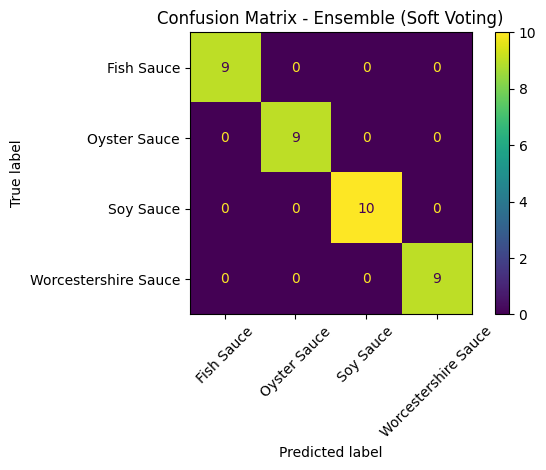

In [2]:
main_voc_df = pd.read_csv("final_trainingset.csv")
X = main_voc_df.drop(columns=["Label"])
y = main_voc_df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# ------------------------
# Encode labels for XGBoost, but keep decoded predictions later
# ------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# ------------------------
# SVM (Bayesian Optimization)
# ------------------------
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("svm", SVC(probability=True, class_weight="balanced", random_state=42))
])

svm_space = {
    "pca__n_components": Integer(2, min(20, X.shape[1])),
    "svm__C": Real(1e-2, 1e3, prior="log-uniform"),
    "svm__gamma": Real(1e-5, 1e-1, prior="log-uniform"),
    "svm__kernel": Categorical(["rbf"])
}

svm_search = BayesSearchCV(
    svm_pipe, svm_space, n_iter=40, cv=cv, scoring="f1_macro",
    n_jobs=-1, random_state=42, refit=True
)
svm_search.fit(X_train, y_train_enc)
best_svm = svm_search.best_estimator_

print("Best SVM params:", svm_search.best_params_)


# ------------------------
# k-NN (Bayesian Optimization)
# ------------------------
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("knn", KNeighborsClassifier())
])

knn_space = {
    "pca__n_components": Integer(2, min(20, X.shape[1])),
    "knn__n_neighbors": Integer(1, 30),
    "knn__weights": Categorical(["uniform", "distance"]),
    "knn__p": Integer(1, 2)
}

knn_search = BayesSearchCV(
    knn_pipe, knn_space, n_iter=40, cv=cv, scoring="f1_macro",
    n_jobs=-1, random_state=42, refit=True
)
knn_search.fit(X_train, y_train_enc)
best_knn = knn_search.best_estimator_

print("Best k-NN params:", knn_search.best_params_)


# ------------------------
# XGBoost (Bayesian Optimization)
# ------------------------
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("xgb", XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42
    ))
])

xgb_space = {
    "pca__n_components": Integer(2, min(20, X.shape[1])),
    "xgb__learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
    "xgb__max_depth": Integer(2, 10),
    "xgb__gamma": Real(0.0, 5.0),
    "xgb__subsample": Real(0.5, 1.0)
}

xgb_search = BayesSearchCV(
    xgb_pipe, xgb_space, n_iter=50, cv=cv, scoring="f1_macro",
    n_jobs=-1, random_state=42, refit=True
)
xgb_search.fit(X_train, y_train_enc)
best_xgb = xgb_search.best_estimator_

print("Best XGBoost params:", xgb_search.best_params_)


# ------------------------
# Voting Ensemble (SOFT voting)
# ------------------------
ensemble = VotingClassifier(
    estimators=[
        ("svm", best_svm),
        ("knn", best_knn),
        ("xgb", best_xgb)
    ],
    voting="soft"
)

ensemble.fit(X_train, y_train_enc)

# Predict (encoded) -> decode back to original sauce labels
y_pred_enc = ensemble.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

print("\nEnsemble Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report (Ensemble):")
print(classification_report(y_test, y_pred))

# Confusion Matrix (label strings)
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Ensemble (Soft Voting)")
plt.tight_layout()
plt.show()


In [3]:
joblib.dump(ensemble, "ensemble_model.joblib") 
joblib.dump(le, "label_encoder.joblib")
print("Model and label encoder saved")

Model and label encoder saved
